# Above Threshold Building Energy Usage Classification

### Import Data and Libraries

In [22]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# Importing the dataset
df1 = pd.read_csv('../../data/year_data/2018-04-01_2018-04-29.csv')
df2 = pd.read_csv('../../data/year_data/2018-05-01_2018-05-30.csv')
df3 = pd.read_csv('../../data/year_data/2018-06-01_2018-08-30.csv')
df =  pd.concat([df1, df2, df3], ignore_index=True)

## Functions

#### Dataframe Manipulation

In [23]:
# Slices the Dataframe by both Date and Buildings
def slice_df(start_date, num_days=7, num_min=0, bldgs=None, df=df):
    start, end = slice_df_by_date(start_date, num_days, num_min, df)
    return slice_df_by_bldg(bldgs, df.iloc[start:end,:])

# Returns starting and ending indexes of data splice
def slice_df_by_date(start_date, num_days=7, num_min=0, df=df):
    start = df.index[df['time'] == start_date + ' 00:00'].tolist()[0]
    end = start + num_days * 96 + num_min % 15
    return start, end

# Returns df of Selected Columns (None == All)
def slice_df_by_bldg(bldgs=None, df=df):
    if bldgs == None: return df.iloc[:, 1:]
    else: return df[bldgs]

# Split Time Stamp Column to Two Columns; Date and Time
def split_date_time(df=df):
    df[date] = df[time].apply(lambda x: x.split(x)[0], axis = 1)
    df[time] = df[time].apply(lambda x: x.split(x)[1], axis = 1)


# Group By Interval with some Method
# Methods: Sum, Mean, Min, or Max
# Returns a df of grouped data
def group_df(method="mean", interval='day', has_time_col=True, df=df):
    interval = time_to_row(interval)
    grouped_df = pd.DataFrame()   
    for i in range(0,len(df)//interval):
        if has_time_col: start_date = df['time'][i*interval]
        block = df.iloc[ i*interval:(i+1)*interval, : ]
        # Perform Computation on Row
        if method == "sum": block = block.sum(axis=0)
        elif method == "mean": block = block.mean(axis=0)
        elif method == "min": block = block.min(axis=0)
        elif method == "max": block = block.max(axis=0)
        else:
            print("Invalid Method Entry")
            return
        # Add the Start Date Label
        if has_time_col:
            if method == "mean": block = pd.Series([start_date]).append(block)  
            else: block[0] = start_date
        block = block.to_frame().transpose()
        grouped_df = grouped_df.append(block)
    if method == "mean" and has_time_col: grouped_df = grouped_df.rename(columns={ grouped_df.columns[0]: "time" })
    return grouped_df

# Create Training Data
def training_data(start_date, y=None, num_days=7, num_min=0, bldgs=None, method="mean", agg_interval='hour',
                  time_interval="day", has_time_col=True, df=df):
    # Slice Data by Time and Buildings
    X = slice_df(start_date, num_days, num_min, bldgs, df)
    X = X.rename(columns={ X.columns[0]: "time" })
    # Aggregate Data on Interval
    X = group_df(method=method, interval=agg_interval, has_time_col=False, df=X)
    if has_time_col: X = X.drop(columns=['time'])
    # Determine Shape of New Dataframe and Reshape
    new_col_ct = int(time_to_row(time_interval)/time_to_row(agg_interval))
    rows_per_instance = int(X.shape[0]/new_col_ct)
    X = X.T.values.reshape(X.shape[1] * rows_per_instance, new_col_ct)
    # Return X or both X and updated y if y is given
    if y == None: return pd.DataFrame(X)
    updated_y = []
    for i in y:
        for j in range(0, rows_per_instance): updated_y.append(i)
    return pd.DataFrame(X), updated_y

#### Conversion

In [24]:
# Convert a time interval into the correct number of rows
# Interval: "3:15", "hour", day", "week", "month", "year" 
def time_to_row(interval):
    time_conv =	{ "year": 35040, "month": 2880, "week": 672, "day": 96, "hour": 4}
    if interval in time_conv: return time_conv[interval]
    elif ":" in interval: return int(interval.split(':')[0])*4 + int(interval.split(':')[1])//15
    else: return

# Converts the Date into a Number
def date_to_num(date):
    d,t = date.split()
    y,m,day = d.split('-')
    hr, minute = t.split(':')
    return int(y + m + day + hr + minute)

# Converts Traditional Date Format '4/4/2018' to ISO '2018-04-01'
def date_to_iso(date):
    month, day, year = date.split('/')
    if (int(month) < 10): month = '0' + str(int(month))
    if (int(day) < 10): day = '0' + str(int(day))
    return year + '-' + month + '-' + day

# Converts a Date Number to Proper Date Format
def num_to_date(date):
    date = str(date)
    return date[0:4] + '-' + date[4:6] + '-' + date[6:8] + ' ' + date[8:10] + ':' + date[10:12]

# Convert Number to Building Type Classification
def num_to_label(num):
    conv = {0: 'Cocentric', 1: 'People', 2: 'Schedule', 3: 'Reverse', 4: 'Random'}
    if num in conv: return conv[num]
    return "Invalid Entry"

# Returns rotates array n times, clockwise by default
def rotate_list(arr, n):
    arr = list(arr)
    if n >= 0: return arr[-n:] + arr[:-n]
    return arr[abs(n):] + arr[:abs(n)]

# Convert From LabelEncoded to OneHotEncoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def label_to_one_hot(y):
    one_hot_encoder = OneHotEncoder()
    return one_hot_encoder.fit_transform(y).toarray()

# Convert From OneHotEncoded to LabelEncoded
def one_hot_to_label(y):
    return [ np.argmax(i) for i in y ]

#### Fingerprint Generation

In [25]:
def fingerprint_draw(bldg, save=False, show=False, df=df):
    r = df[bldg]
    theta = []
    for i in range(0, len(r)):
        theta.append((i%96)/96 * 2 * np.pi)
    r = r.append(pd.Series(r.values[0]))
    theta.append(0)
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar', facecolor='white')
    ax.plot(theta, r, c='y')
    ax.set_xticklabels(['12am', '3am', '6am', '9am', '12pm', '3pm', '6pm', '9pm'])
    plt.figure(figsize=(4,4))
    ax.set_rlabel_position(90)
    ax.grid(True)
    ax.grid(linewidth=.3)
    ax.set_title("Energy Usage of Building " + bldg + " (kWh)", va='bottom')
    ax.title.set_position([.5, 1.15])
    if save: fig.savefig('fingerprints/' + bldg + '.png', bbox_inches='tight')
    if show: plt.show()

#fingerprint('2018-02-08', 1, bldgs=['B104'], save=False)
#fingerprint('2018-01-01', 1)
#fingerprint('2018-01-01', num_days=5, save=True)
def fingerprint(start_date, num_days=7, num_min=0, bldgs=None, save=True, df=df):
    df = slice_df(start_date, num_days, num_min, bldgs, df)    
    for bldg in df.columns: fingerprint_draw(bldg, save, df=df)

### Data Manipulation

In [26]:
# Returns a Stacked dataframe with each rotation of each row
def rotate_data(X, y, iterations = 1, ret_orig = True):
    final_X, final_y = pd.DataFrame(), pd.DataFrame()
    for itr in range(0, iterations):
        new_df = []
        for i in range(0, X.shape[0]):
            new_df.append(rotate_list( X.iloc[i, :].values, itr - (iterations // 2) ))
        final_X = pd.concat([final_X, pd.DataFrame(new_df)])
        final_y = pd.concat([final_y, pd.DataFrame(y)])
    if ret_orig: return pd.concat([X, final_X]), pd.concat([y, final_y])
    return final_X, final_y

# Remove Buildings With Energy Usage Below 60 kwH
def remove_small(X, y, thresh=75):
    final_X, final_y = pd.DataFrame(), pd.DataFrame()
    y_list = list(y.iloc[:, 0])
    new_df = []
    new_y = []
    for i in range(0, X.shape[0]):
        if X.iloc[i, :].mean() > thresh:
            new_df.append(X.iloc[i, :].values)
            new_y.append(y_list[i])
    final_X = pd.concat([final_X, pd.DataFrame(new_df)])
    final_y = pd.concat([final_y, pd.DataFrame(new_y)])
    return final_X, final_y


# Subtract Row Elements by Min Value in Row
def minus_min(X):
    new_X = []
    for i in range(0, X.shape[0]): new_X.append(X.iloc[i, :] - min(X.iloc[i, :]))
    return pd.DataFrame(new_X)

# Normalize Each Row Independently
from sklearn.preprocessing import normalize
def norm_rows(X):
    new_X = []
    for i in range(0, X.shape[0]):
        new_row = [list(X.iloc[i, :])]
        new_row = normalize(new_row)
        new_X.append(new_row)
    return pd.DataFrame(new_X)

# Square Each Row Independently
def square_rows(X):
    new_X = []
    for i in range(0, X.shape[0]):
        new_row = X.iloc[i, :]
        for i,v in enumerate(new_row):
            new_row[i] = v*v
        new_X.append(new_row)
    return pd.DataFrame(new_X)

#### Accuracy Reporting

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Use this function for non-binary classification
def confusion_matrix_multi(y_test, y_pred):
    if pd.DataFrame(y_pred).shape[1] == 1:
        y_pred = label_to_one_hot(pd.DataFrame(y_pred))
    conf_mat = confusion_matrix(one_hot_to_label(y_test), one_hot_to_label(y_pred))
    fig, ax = plt.subplots(figsize=(10,10))
    classes = ['Cocentric', 'People', 'Schedule', 'Reverse', 'Random']
    sns.heatmap(conf_mat, annot=True, fmt='d',
                    xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    accuracy = conf_mat_acc(conf_mat)
    plt.title('Accuracy: ' + str(accuracy) + '%', fontsize=20)
    plt.show()
    return accuracy

# Calculates the Accuracy for any n by n conf matrix
def conf_mat_acc(conf_mat):
    acc = 0
    for i in range(0, len(conf_mat)):
        for j in range(0, len(conf_mat)):
            if i == j: acc += conf_mat[i][j]
    acc = acc/sum(sum(conf_mat))
    acc = round(acc * 100, 2)
    return acc

# Print All Misclassified Instances
def print_misclassified(predicted, actual, X_test, y_test, y_pred, sc, relabel=False):
    y_test = one_hot_to_label(y_test)
    y_pred = one_hot_to_label(y_pred)
    X_test = pd.DataFrame(sc.inverse_transform(X_test))
    for i in range(0, X_test.shape[0]):
        if(y_pred[i] == predicted and y_test[i] == actual):
            title = "Predicted: " + num_to_label(predicted) + ". Actual: " + num_to_label(actual)
            fingerprint_draw_r( title, X_test.iloc[i, :], save=False, show=True, df=df)
            if relabel: search_fingerprint(X_test.iloc[i, :])
                
# Search Data For Fingerprint Match to Relabel the Classification
def search_fingerprint(data, csv='labeled_data.csv'):
    labeled_df = pd.read_csv(csv)
    labeled_dates = labeled_df[labeled_df.columns[0]]
    relabel_val = input("Enter Relabel Value (Enter 'n' to skip): ")
    no_match = True
    if relabel_val in ['0', '1', '2', '3', '4']:
        for date in labeled_dates:
            sliced_df = slice_df(date_to_iso(date), num_days=1, df=df)
            sliced_df = sliced_df.reset_index(drop=True)
            for col in sliced_df:
                if round(data[0], 2) == sliced_df.at[0, col]:
                    for i in range(0,96):
                        if( round(data[i], 2) != sliced_df.at[i, col]): break
                        if(i == 95): 
                            no_match = False
                            print("Building: " + col + ' on ' + date + ' updated to ' + str(relabel_val))
                            update_label(col, date, int(relabel_val))
    if no_match: print('No Matches')

# Print all Misclassified Instances
def print_all_misclassified(X_test, y_test, y_pred, sc):
    for i in range(0, 5):
        for j in range(0, 4):
            if i != j: print_misclassified(i, j, X_test, y_test, y_pred, sc, relabel=True)

#### Data Update

In [28]:
# bldg - str, date (mm/dd/yy) - str, update_val (label 0-4) - str, csv (file to update) - string
def update_label(bldg, date, update_val, csv='labeled_data.csv'):
    df = pd.read_csv(csv)
    index = df.index[df[df.columns[0]] == date].tolist()[0]
    df.at[index, bldg] = update_val
    df.to_csv(csv, index=False)

#### Classification Tools

In [29]:
# Plot the Feature Importances After Creating a Decision Tree Classifying Object
def plot_feature_importances(model, n_features):
    plt.figure(figsize=(8,6))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title("Decision Tree Feature Importance")
    plt.show()
    
from sklearn.neighbors import KNeighborsClassifier
# Test Different Values of k for K-NN Classification
def knn_test_k(start=1, end=10):
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(start, end)
    for n_neighbors in neighbors_settings:
        knn = KNeighborsClassifier(p=2, n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        training_accuracy.append(knn.score(X_train, y_train))
        test_accuracy.append(knn.score(X_test, y_test))
    plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.legend()
    plt.show()
    return test_accuracy.index(max(test_accuracy)) + 1
    #plt.savefig('knn_compare_model')

## Data Preprocessing

#### Format Labeled Data

In [30]:
#update_label('B110', '4/6/2018', 0)
y_labels = pd.read_csv('../../data/labeled_data.csv')
y_labels

,Unnamed: 0,B101,B103,B104,B107,B108,B109,B110,B111,B114,...,B051D,B051F,B051F_C1,B051F_C2,B051F_C3,B060A,B061A,B080A,B172W,B195W
0,4/4/2018,1,0,1,0,3,0,0,1,1,...,0,4,4,4,4,0,4,1,3,NaN
1,4/5/2018,1,0,1,0,4,0,0,0,0,...,0,4,4,4,4,0,4,2,2,NaN
2,4/6/2018,1,0,1,0,0,0,0,1,0,...,0,0,4,4,4,0,4,1,0,NaN
3,4/9/2018,1,0,1,0,3,0,0,0,0,...,0,0,4,4,4,0,4,2,0,NaN
4,4/10/2018,1,0,1,0,0,0,0,0,0,...,0,4,0,4,4,0,4,2,0,NaN
5,4/11/2018,1,0,1,0,0,0,0,0,1,...,0,0,0,4,2,0,4,2,0,NaN
6,4/12/2018,1,0,1,0,0,0,0,0,1,...,0,4,0,4,4,0,4,2,0,NaN
7,4/13/2018,1,0,1,0,0,0,0,0,0,...,0,0,4,4,2,0,4,1,0,NaN
8,6/21/2018,1,0,1,0,0,0,0,0,1,...,0,4,4,4,4,1,4,1,0,NaN
9,6/22/2018,1,0,1,0,0,0,0,0,0,...,0,0,4,4,4,2,4,1,0,NaN


In [31]:
y1 = y_labels.iloc[:3, :]
y1 = y1.melt()
y1 = pd.DataFrame(y1.iloc[3:len(y1)-3,1])

# Get Original Data
X1 = training_data(start_date='2018-04-04', y=None, num_days=3, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y1.shape[0] == X1.shape[0]

True

In [32]:
y2 = y_labels.iloc[3:8, :]
y2 = y2.melt()
y2 = pd.DataFrame(y2.iloc[5:len(y2)-5,1])

X2 = training_data(start_date='2018-04-09', y=None, num_days=5, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y2.shape[0] == X2.shape[0]

True

In [33]:
y3 = y_labels.iloc[8:10, :]
y3 = y3.melt()
y3 = pd.DataFrame(y3.iloc[2:len(y3)-2, 1])

X3 = training_data(start_date='2018-06-21', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y3.shape[0] == X3.shape[0]

True

In [34]:
y4 = y_labels.iloc[10:15, :]
y4 = y4.melt()
y4 = pd.DataFrame(y4.iloc[5:len(y4)-5, 1])

X4 = training_data(start_date='2018-06-25', y=None, num_days=5, num_min=0, method="mean", agg_interval='0:15',
        time_interval="day", has_time_col=False, df=df)

y4.shape[0] == X4.shape[0]

True

In [35]:
y5 = y_labels.iloc[15:17, :]
y5 = pd.DataFrame(y5).melt()
y5 = pd.DataFrame(y5.iloc[2:len(y5)-2, 1])

X5 = training_data(start_date='2018-07-02', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y5.shape[0] == X5.shape[0]

True

In [36]:
y6 = y_labels.iloc[17:19, :]
y6 = pd.DataFrame(y6).melt()
y6 = pd.DataFrame(y6.iloc[2:len(y6)-2, 1])

X6 = training_data(start_date='2018-07-05', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y6.shape[0] == X6.shape[0]

True

In [37]:
y7 = y_labels.iloc[19:22, :]
y7 = pd.DataFrame(y7).melt()
y7 = pd.DataFrame(y7.iloc[3:len(y7)-3, 1])

X7 = training_data(start_date='2018-07-09', y=None, num_days=3, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y7.shape[0] == X7.shape[0]

True

#### Concat

In [38]:
y = pd.concat([y1, y2, y3, y4, y5, y6, y7], axis=0)
y.shape

(2926, 1)

In [39]:
X = pd.concat([X1, X2, X3, X4, X5, X6, X7], axis=0)
X.shape

(2926, 96)

In [40]:
# Remove Buildings With Energy Usage Below Threshold
X, y = remove_small(X, y, 125)

In [41]:
X.shape

(1076, 96)

#### One Hot Encode Y Values

In [42]:
y = label_to_one_hot(y)

#### Splitting the dataset into the Training set and Test set

In [43]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

C:\Users\Kunal\Anaconda\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Feature Scaling

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [45]:
# Multiply Datasize
X_train_n, y_train_n = rotate_data(pd.DataFrame(X_train), pd.DataFrame(y_train), 10, ret_orig=False)
X_train = pd.concat([pd.DataFrame(X_train), X_train_n])
y_train = pd.concat([pd.DataFrame(y_train), y_train_n])
X_train = X_train.values
y_train = y_train.values
print('Final Shapes:')
print(X_train.shape)
print(y_train.shape)

Final Shapes:
(9460, 96)
(9460, 5)


## Classification

### Decision Tree Classification

C:\Users\Kunal\Anaconda\envs\py35\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


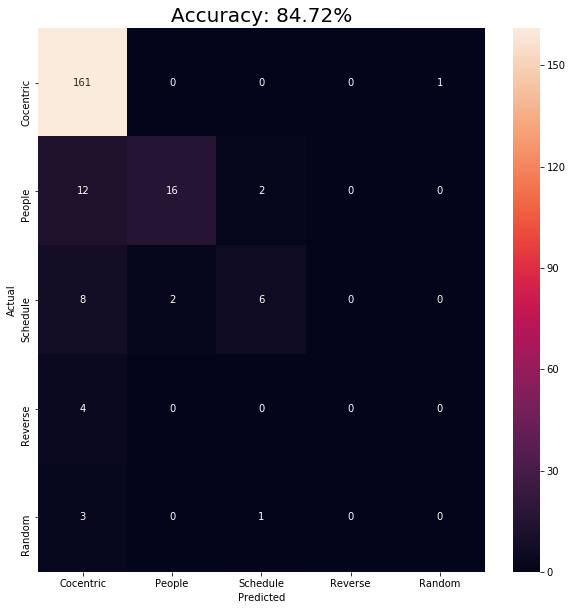

84.72

In [46]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', min_impurity_split=0.27)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
confusion_matrix_multi(y_test, y_pred)

In [47]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

In [48]:
#plot_feature_importances(classifier,96)

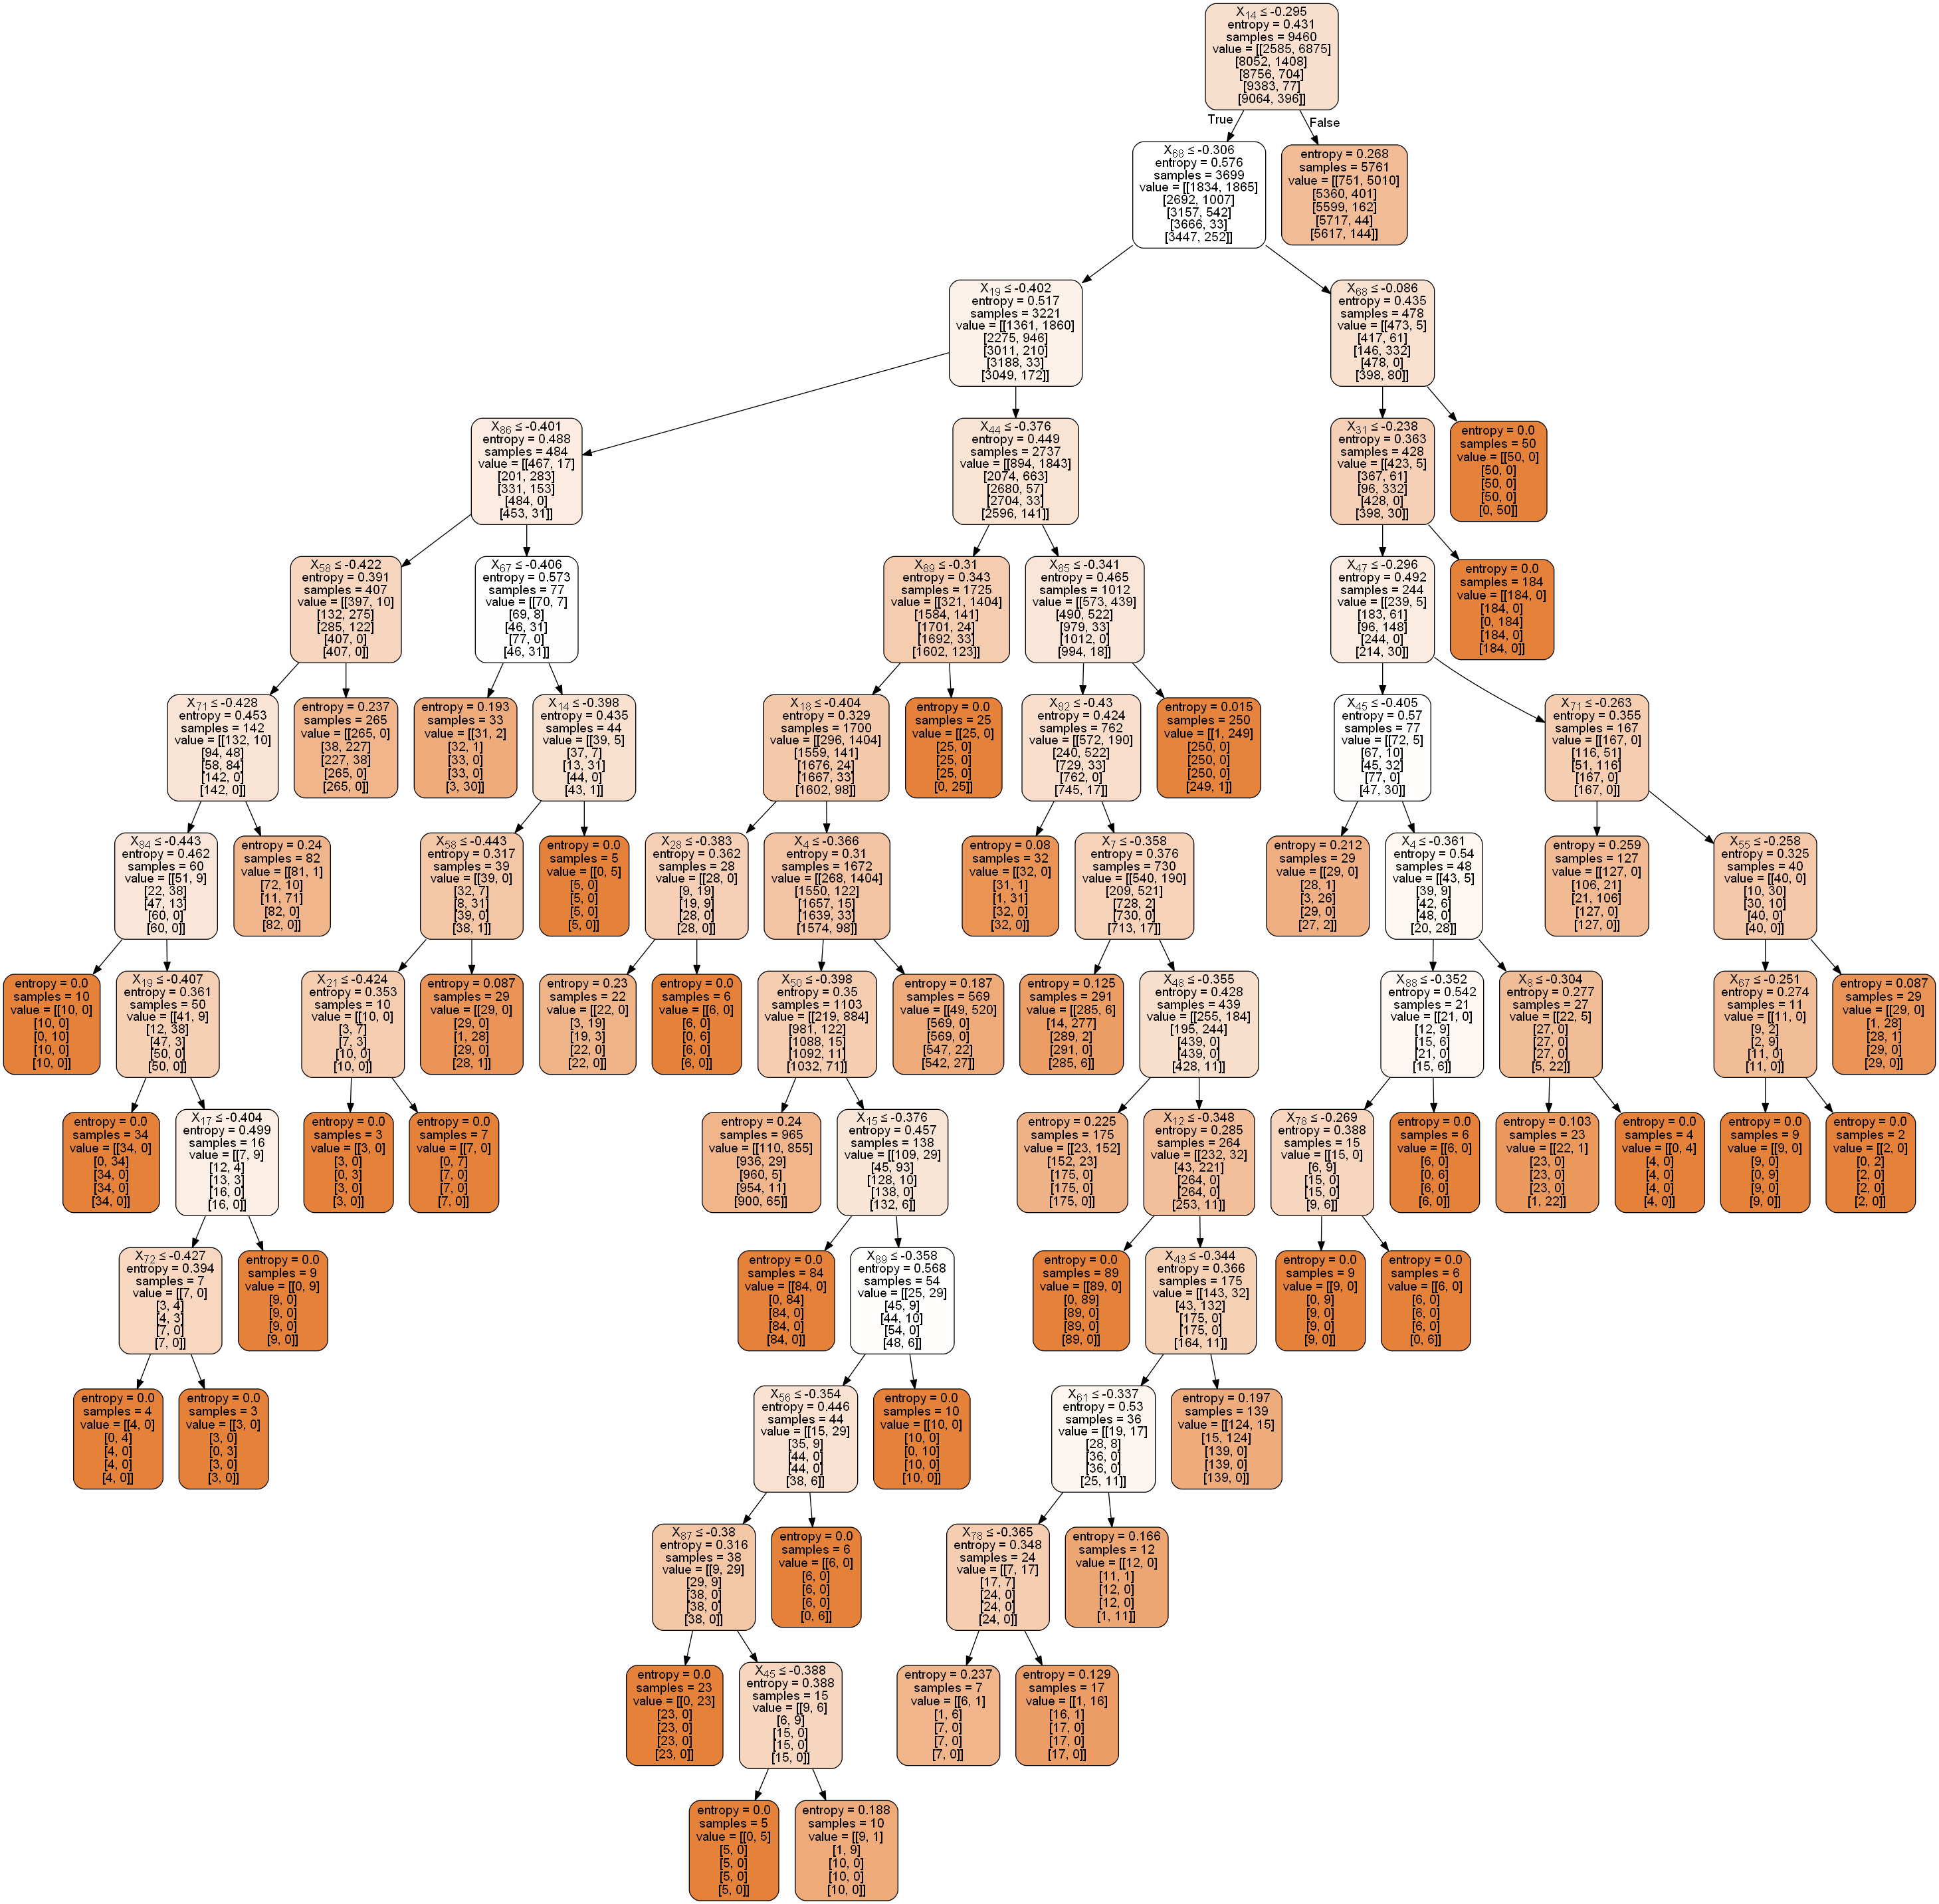

In [49]:
# Visualize Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Random Forest Classification

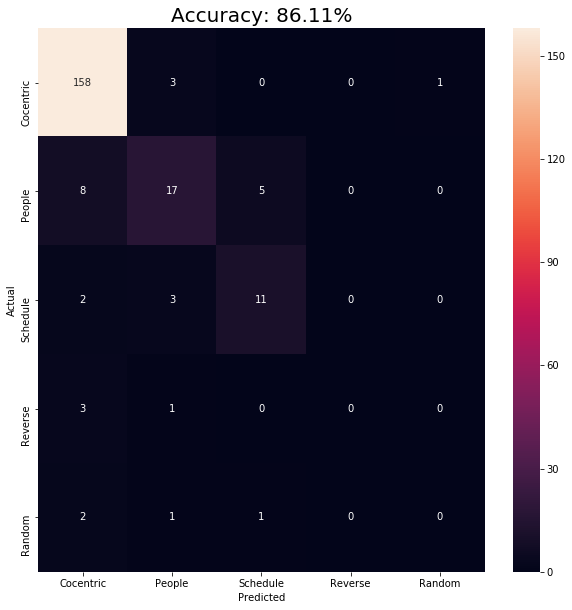

86.11

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy') 
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
confusion_matrix_multi(y_test, y_pred)

In [51]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

### K-NN Classification

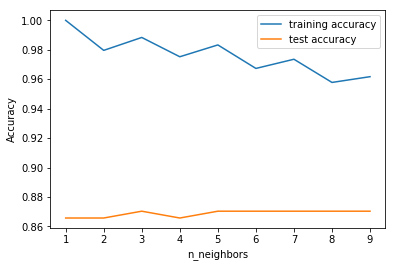

In [52]:
best_k = knn_test_k()

Optimal k Value: 3


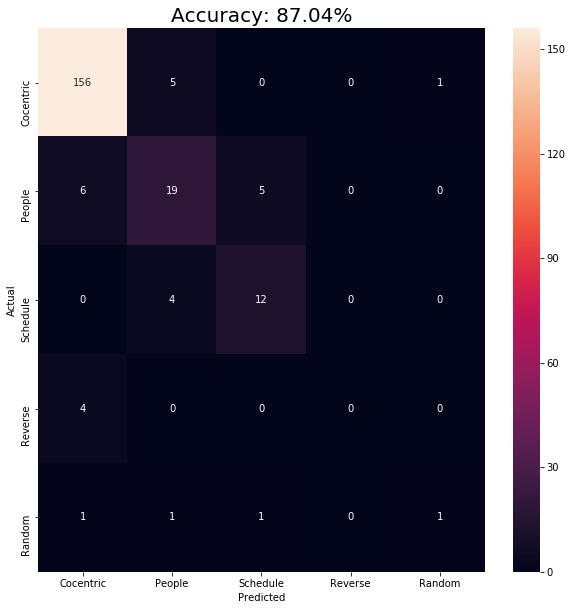

87.04

In [53]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = best_k, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
print('Optimal k Value: ' + str(best_k))
confusion_matrix_multi(y_test, y_pred)

In [54]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

### Artificial Neural Network Classification

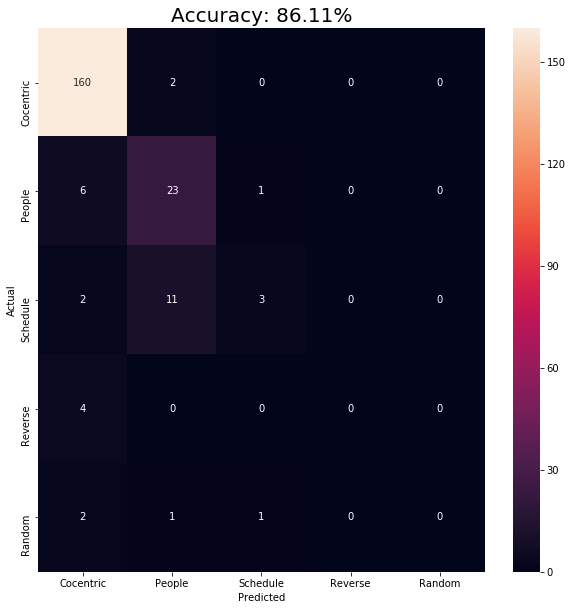

86.11

In [55]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 8), max_iter=300)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
confusion_matrix_multi(y_test, y_pred)

### Ensemble Classification

In [56]:
# Voting Ensemble for Classification
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
estimators.append(('Random Forest', rf_classifier))
estimators.append(('KNN', knn_classifier))
estimators.append(('ANN', mlp))
# create the ensemble model
ensemble = VotingClassifier(estimators)
#results = model_selection.cross_val_score(ensemble, X_train, one_hot_to_label(y_train), cv=kfold)

C:\Users\Kunal\Anaconda\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


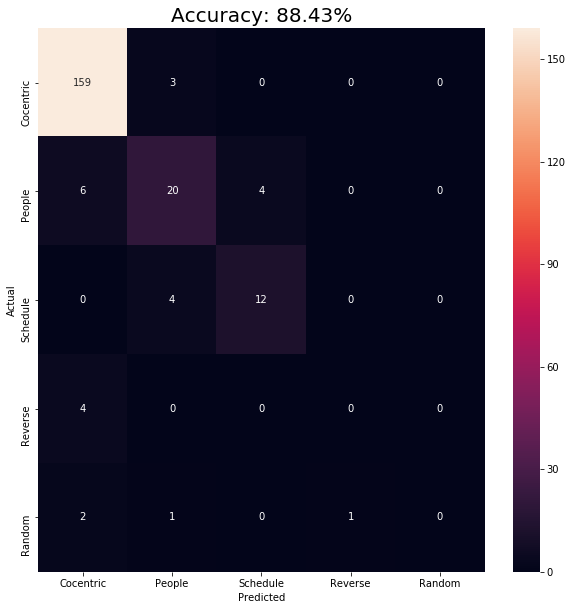

88.43

In [57]:
ensemble = ensemble.fit(X_train, one_hot_to_label(y_train))
y_pred_ensemble = ensemble.predict(X_test)
confusion_matrix_multi(y_test, y_pred_ensemble)

In [58]:
# Save Results
import pickle
# save the model to disk
filename = 'building_classification_model.p'
pickle.dump(ensemble, open(filename, 'wb'))

In [59]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#loaded_model = loaded_model.predict(X_test)
#confusion_matrix_multi(y_test, loaded_model)

In [60]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

In [61]:
x = [0,25, 50, 75, 100, 125, 150]
acc = [84.13, 86.08, 88.83, 89.04, 87.55, 89.81, 90.21]
size = [2926, 2366, 1833, 1501, 1243, 1076, 967]

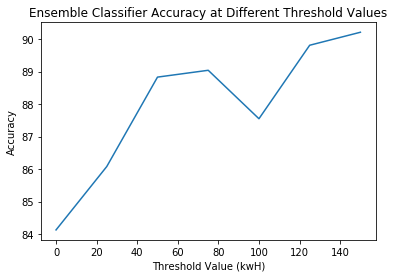

In [62]:
plt.plot(x, acc)
plt.title('Ensemble Classifier Accuracy at Different Threshold Values')
plt.xlabel('Threshold Value (kwH)')
plt.ylabel('Accuracy')
plt.show()

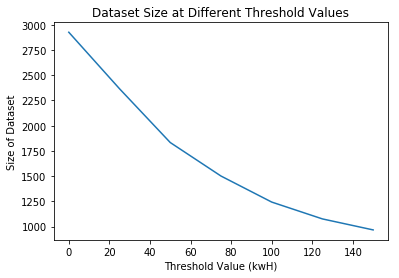

In [63]:
plt.plot(x, size)
plt.title('Dataset Size at Different Threshold Values')
plt.xlabel('Threshold Value (kwH)')
plt.ylabel('Size of Dataset')
plt.show()